In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import sys
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train = pd.read_csv("/kaggle/input/jane-street-market-prediction/train.csv")  
features = pd.read_csv("/kaggle/input/jane-street-market-prediction/features.csv")       


/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [6]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

# 1. EDA

# 1.1 Inspecting tables

In [7]:
# Reduce the memory
train = reduce_memory_usage(train)
train.head(5)

Memory usage of dataframe is 2516.843978881836 MB
Memory usage of dataframe after reduction 1247.0233011245728 MB
Reduced by 50.45289610369131 % 


date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174379   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313582     1.782433    14.018213     2.653056    12.600291   
1     1.777472    -0.915459     2.831612    -1.417010     2.297459   
2     9.667908     5.542871    11.671595     7.281757    10.060014   
3     0.499251     3.033731     1.513488     4.397532     1.266037   
4     4.101145     0.614252     6.623456     0.800129     5.233243   

   feature_128  feature_129  ts_id  
0     2.301488    11.445807      0  
1    -1.304614     1.898684      1  
2     6.638248     9.427299      2  
3     3.856384     1.013469      3  
4     0.362636     3.926633      4  

[5 rows x 138 columns]

In [8]:
train.loc[train['resp']>0.0,'action']=1
train['action'] = train['action'].fillna(0)

In [9]:
train.head(5)

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_122  feature_123  \
0          1  -1.872746  -2.191242  ...     1.168391     8.313583   
1         -1  -1.349537  -1.704709  ...    -1.178850     1.777472   
2         -1   0.812780  -0.256156  ...     6.115747     9.667908   
3         -1   1.174378   0.344640  ...     2.838853     0.499251   
4          1  -3.172026  -3.093182  ...     0.344850     4.101145   

   feature_124  feature_125  feature_126  feature_127  feature_128  \
0     1.782433    14.018213     2.653056    12.600292     2.301488   
1    -0.915458     2.831612    -1.417010     2.297459    -1.304614   
2     5.542871    11.671595     7.281757    10.060014     6.638248   
3     3.033732     1.513488     4.397532     1.266037     3.856384   
4     0.614252     6.623456     0.800129     5.233243     0.362636   

   feature_129  ts_id  action  
0    11.445807      0     1.0  
1     1.898684      1     0.0  
2     9.427299      2     1.0  
3     1.013469      3     0.0  
4     3.926633      4     0.0  

[5 rows x 139 columns]

#### As this is a time series each row corresponds to a period of time, the time period of each row needs calculating as well as working out how many days data we have been given. A stock broker year is 250 days

In [2]:
# Inspecting the weight column
Col = train['weight']
Col.head(10)

NameError: name 'train' is not defined

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weight', ylabel='Density'>

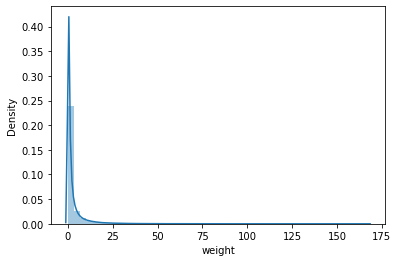

In [18]:
sns.distplot(Col)

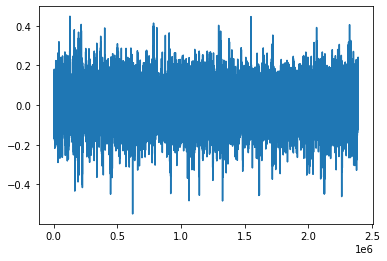

In [24]:
plt.plot(train['resp'])

[]

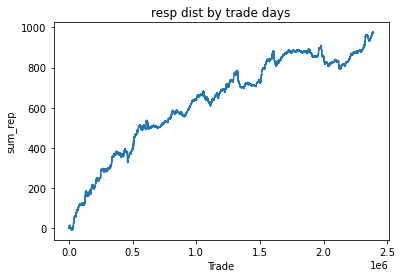

In [20]:
plt.plot(train['resp'].cumsum())
plt.xlabel('Trade')
plt.ylabel('sum_rep')
plt.title('resp dist by trade days')
plt.plot()

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

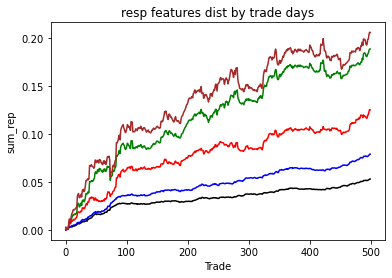

In [25]:
plt.plot((train.groupby('date')['resp'].mean()).cumsum(),'green')
plt.plot((train.groupby('date')['resp_1'].mean()).cumsum(),'black')
plt.plot((train.groupby('date')['resp_2'].mean()).cumsum(),'blue')
plt.plot((train.groupby('date')['resp_3'].mean()).cumsum(),'red')
plt.plot((train.groupby('date')['resp_4'].mean()).cumsum(),'brown')
plt.xlabel('Trade')
plt.ylabel('sum_rep')
plt.title('resp features dist by trade days')
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

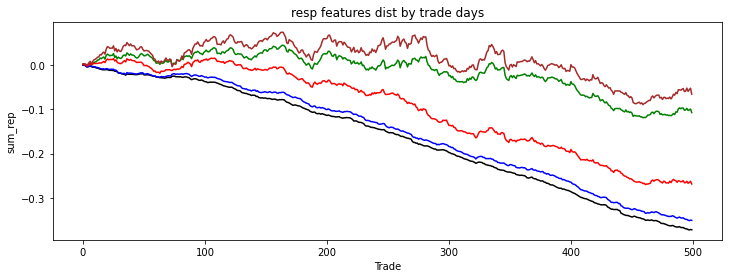

In [26]:
#Each trade have asssociated weight and resp,when sum together gives a return on trade.
train['return_resp']= train['weight']*train['resp']
train['return_resp1']= train['weight']*train['resp_1']
train['return_resp2']= train['weight']*train['resp_2']
train['return_resp3']= train['weight']*train['resp_3']
train['return_resp4']= train['weight']*train['resp_4']

plt.figure(figsize=(12,4))
plt.plot((train.groupby('date')['return_resp'].mean()).cumsum(),'green')
plt.plot((train.groupby('date')['return_resp1'].mean()).cumsum(),'black')
plt.plot((train.groupby('date')['return_resp2'].mean()).cumsum(),'blue')
plt.plot((train.groupby('date')['return_resp3'].mean()).cumsum(),'red')
plt.plot((train.groupby('date')['return_resp4'].mean()).cumsum(),'brown')
plt.xlabel('Trade')
plt.ylabel('sum_rep')
plt.title('resp features dist by trade days')
plt.plot

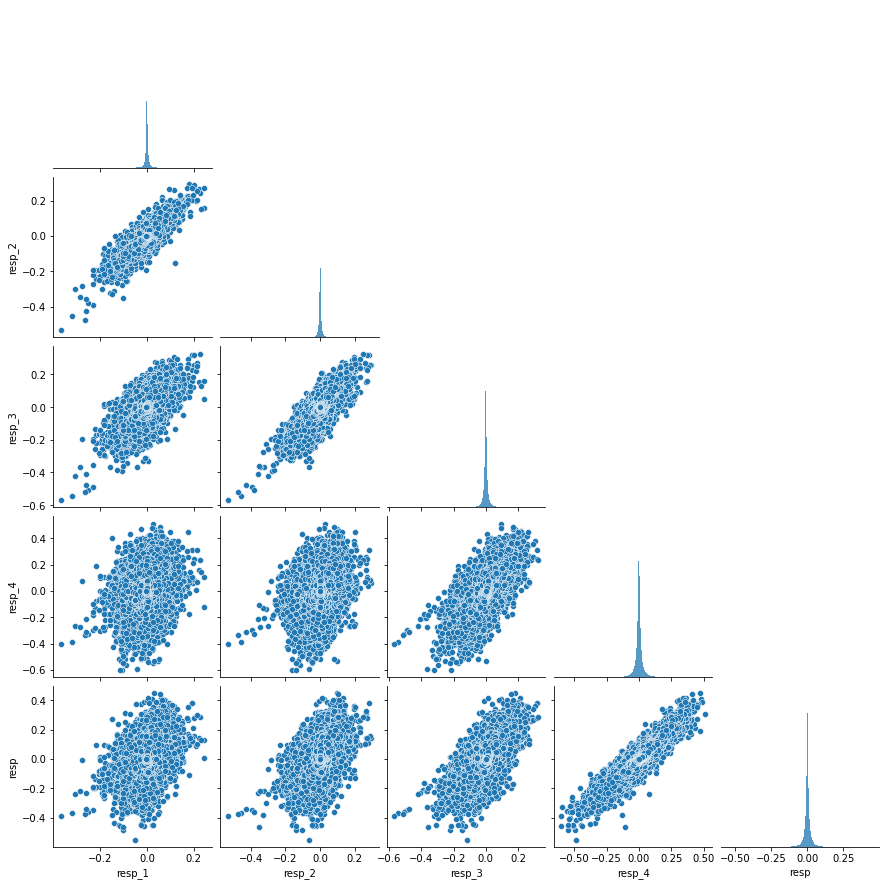

In [27]:
sns.pairplot(train[['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']],corner=True)

5821

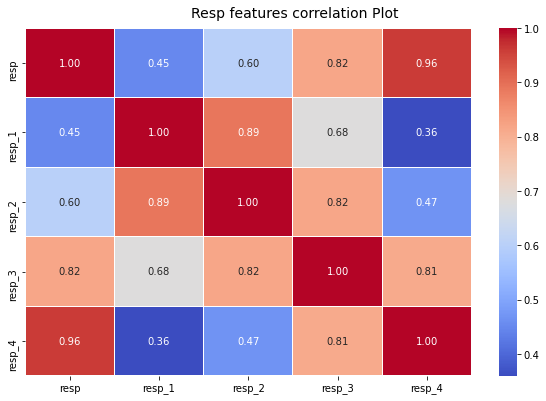

In [31]:
dfgroup1 = train[['resp','resp_1','resp_2','resp_3','resp_4']]
f, ax = plt.subplots(figsize=(10, 6))
corr = dfgroup1.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Resp features correlation Plot', fontsize=14)
del dfgroup1
gc.collect()

In [35]:
Days = train.date.unique()
len(Days)

500

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ts_id', ylabel='Density'>

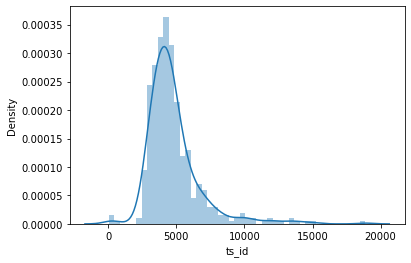

In [40]:

trade_day= train.groupby('date')['ts_id'].count()
trade_day
sns.distplot(trade_day)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(trade_day)
plt.title("Total number of trades per day")
plt.xlabel("days")
plt.ylabel("Count of ts_id")
plt.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
plt.axvspan(0,85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
plt.plot()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 5000.0)

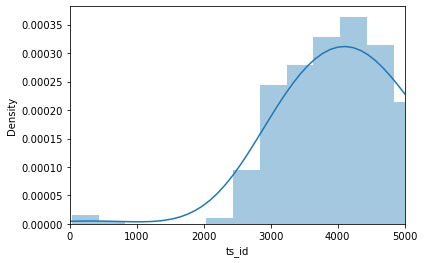

In [41]:
sns.distplot(trade_day)
plt.xlim(0,5000)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(5000.0, 15000.0)

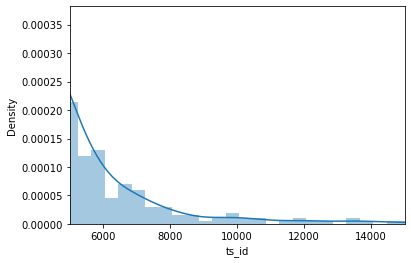

In [42]:
#it can be observe that heavy amount of trades  per day range from 2500 - 9000

sns.distplot(trade_day)
plt.xlim(5000,15000)

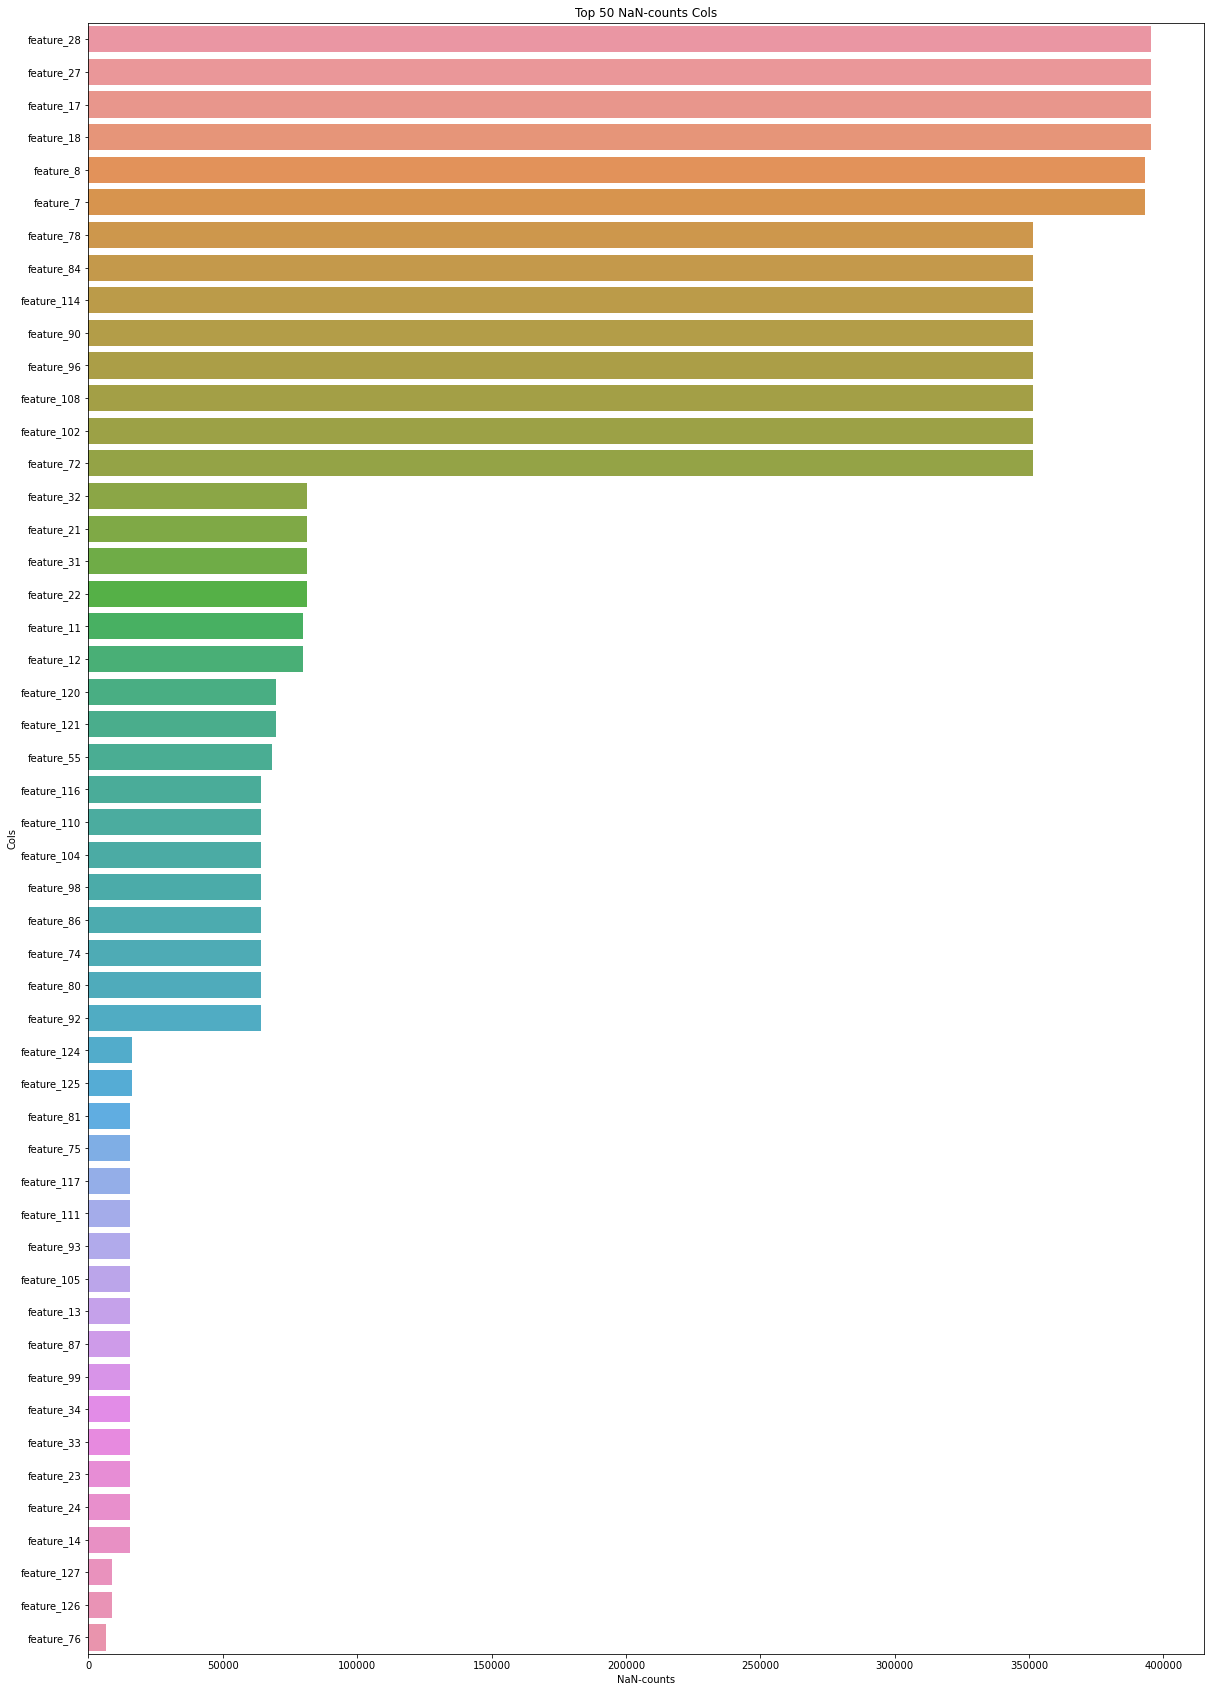

In [44]:
import seaborn as sns
def plot_bar(x, y, df):
    plt.figure(figsize=(20, 30))
    sns.barplot(x=x, y=y, data=df, orient="h")
    plt.title(f"Top {len(df)} {x} {y}")
    plt.show()
    pass
plot_bar(x='NaN-counts', y='Cols', df=dftemp.head(50))

In [43]:
dftemp = train.isna().sum().sort_values(ascending=False).to_frame().reset_index()
dftemp.columns = ["Cols", "NaN-counts"]
for k, v in dftemp.groupby("NaN-counts").groups.items():
    print(f"\n{k}: {dftemp.iloc[v, :]}")


0:              Cols  NaN-counts
88     feature_95           0
89           date           0
90    feature_101           0
91    feature_107           0
92    feature_113           0
93          ts_id           0
94         action           0
95    return_resp           0
96   return_resp1           0
97   return_resp2           0
98   return_resp3           0
99    feature_119           0
100    feature_65           0
101    feature_89           0
102     feature_6           0
103    feature_46           0
104    feature_43           0
105    feature_42           0
106    feature_41           0
107    feature_40           0
108    feature_39           0
109    feature_38           0
110    feature_37           0
111     feature_5           0
112    feature_48           0
113     feature_2           0
114     feature_1           0
115     feature_0           0
116          resp           0
117        resp_4           0
118        resp_3           0
119        resp_2           0
120   

27

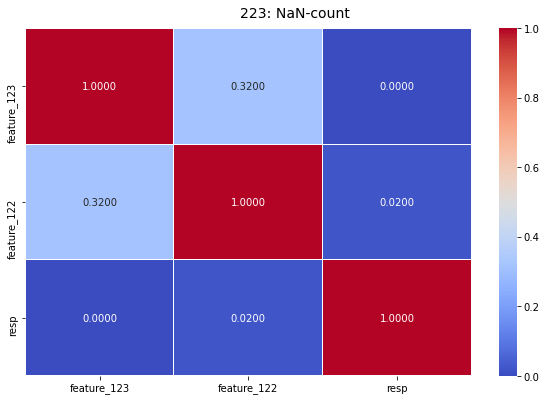

In [8]:
df223 = train[["feature_123", "feature_122","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df223.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=14)
del df223
gc.collect()

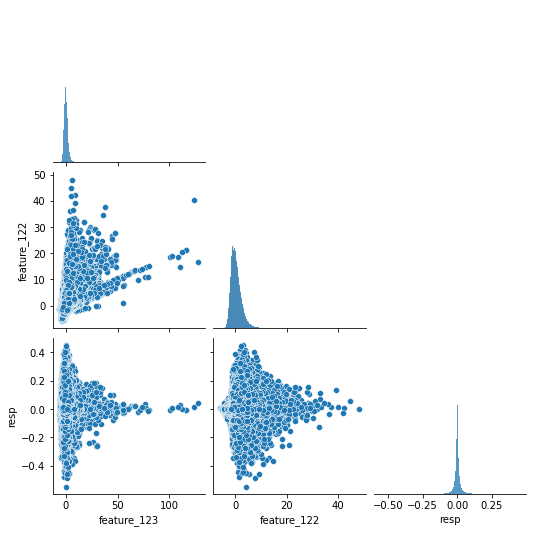

In [63]:
sns.pairplot(train[["feature_123", "feature_122","resp"]],corner=True)

4612

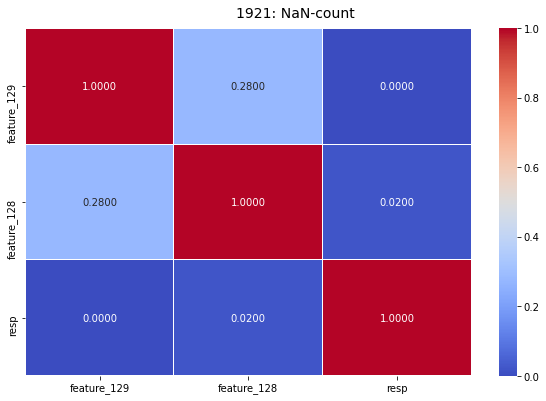

In [9]:
df1921 = train[["feature_129", "feature_128","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df1921.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('1921: NaN-count', fontsize=14)
del df1921
gc.collect()

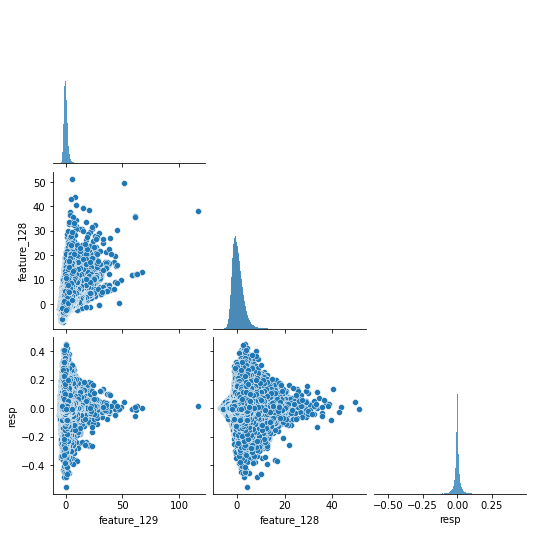

In [64]:
sns.pairplot(train[["feature_129", "feature_128","resp"]],corner=True)

4596

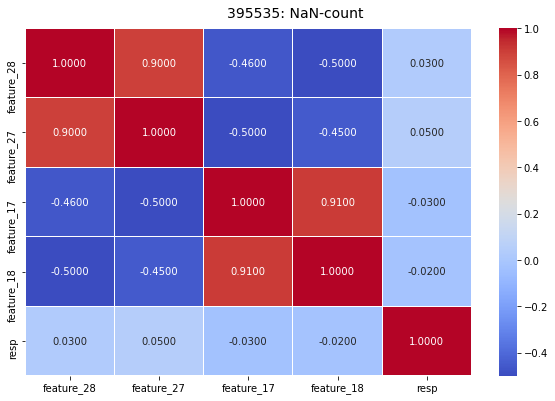

In [10]:
df395535 = train[["feature_28", "feature_27", "feature_17","feature_18","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df395535.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('395535: NaN-count', fontsize=14)
del df395535
gc.collect()

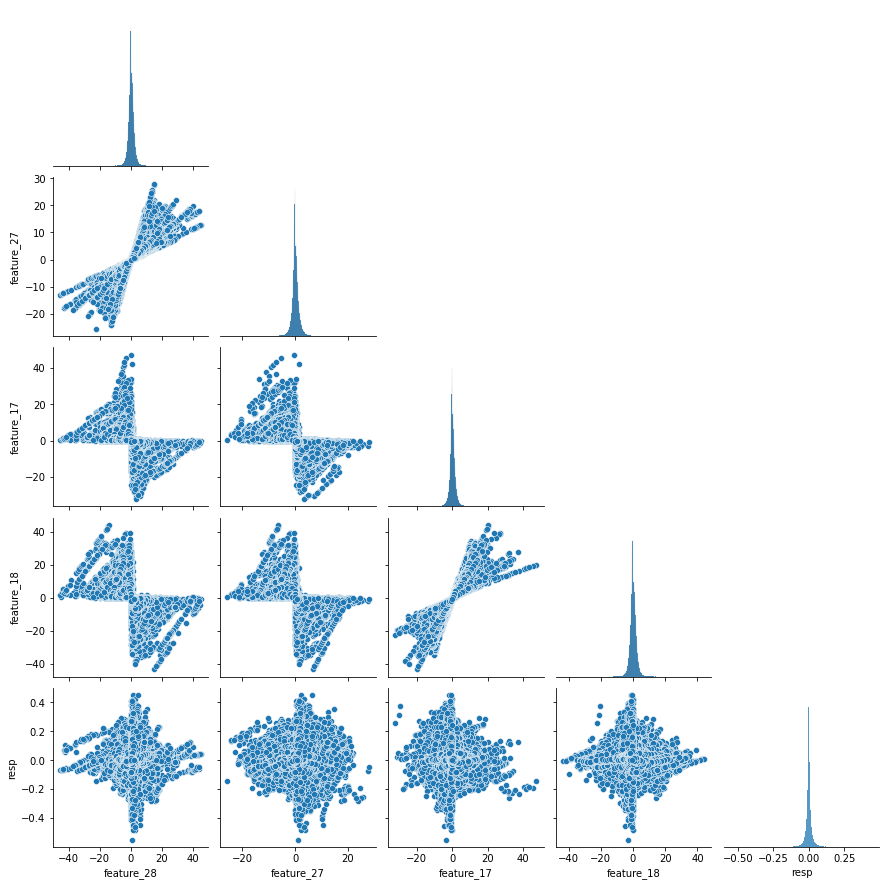

In [65]:
sns.pairplot(train[["feature_28", "feature_27", "feature_17","feature_18","resp"]],corner=True)

5861

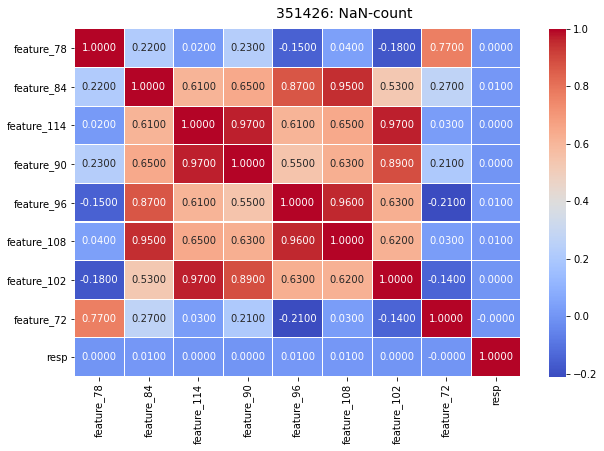

In [11]:
df351426 = train[["feature_78", "feature_84", "feature_114","feature_90","feature_96", "feature_108", "feature_102","feature_72","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df351426.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('351426: NaN-count', fontsize=14)
del df351426
gc.collect()

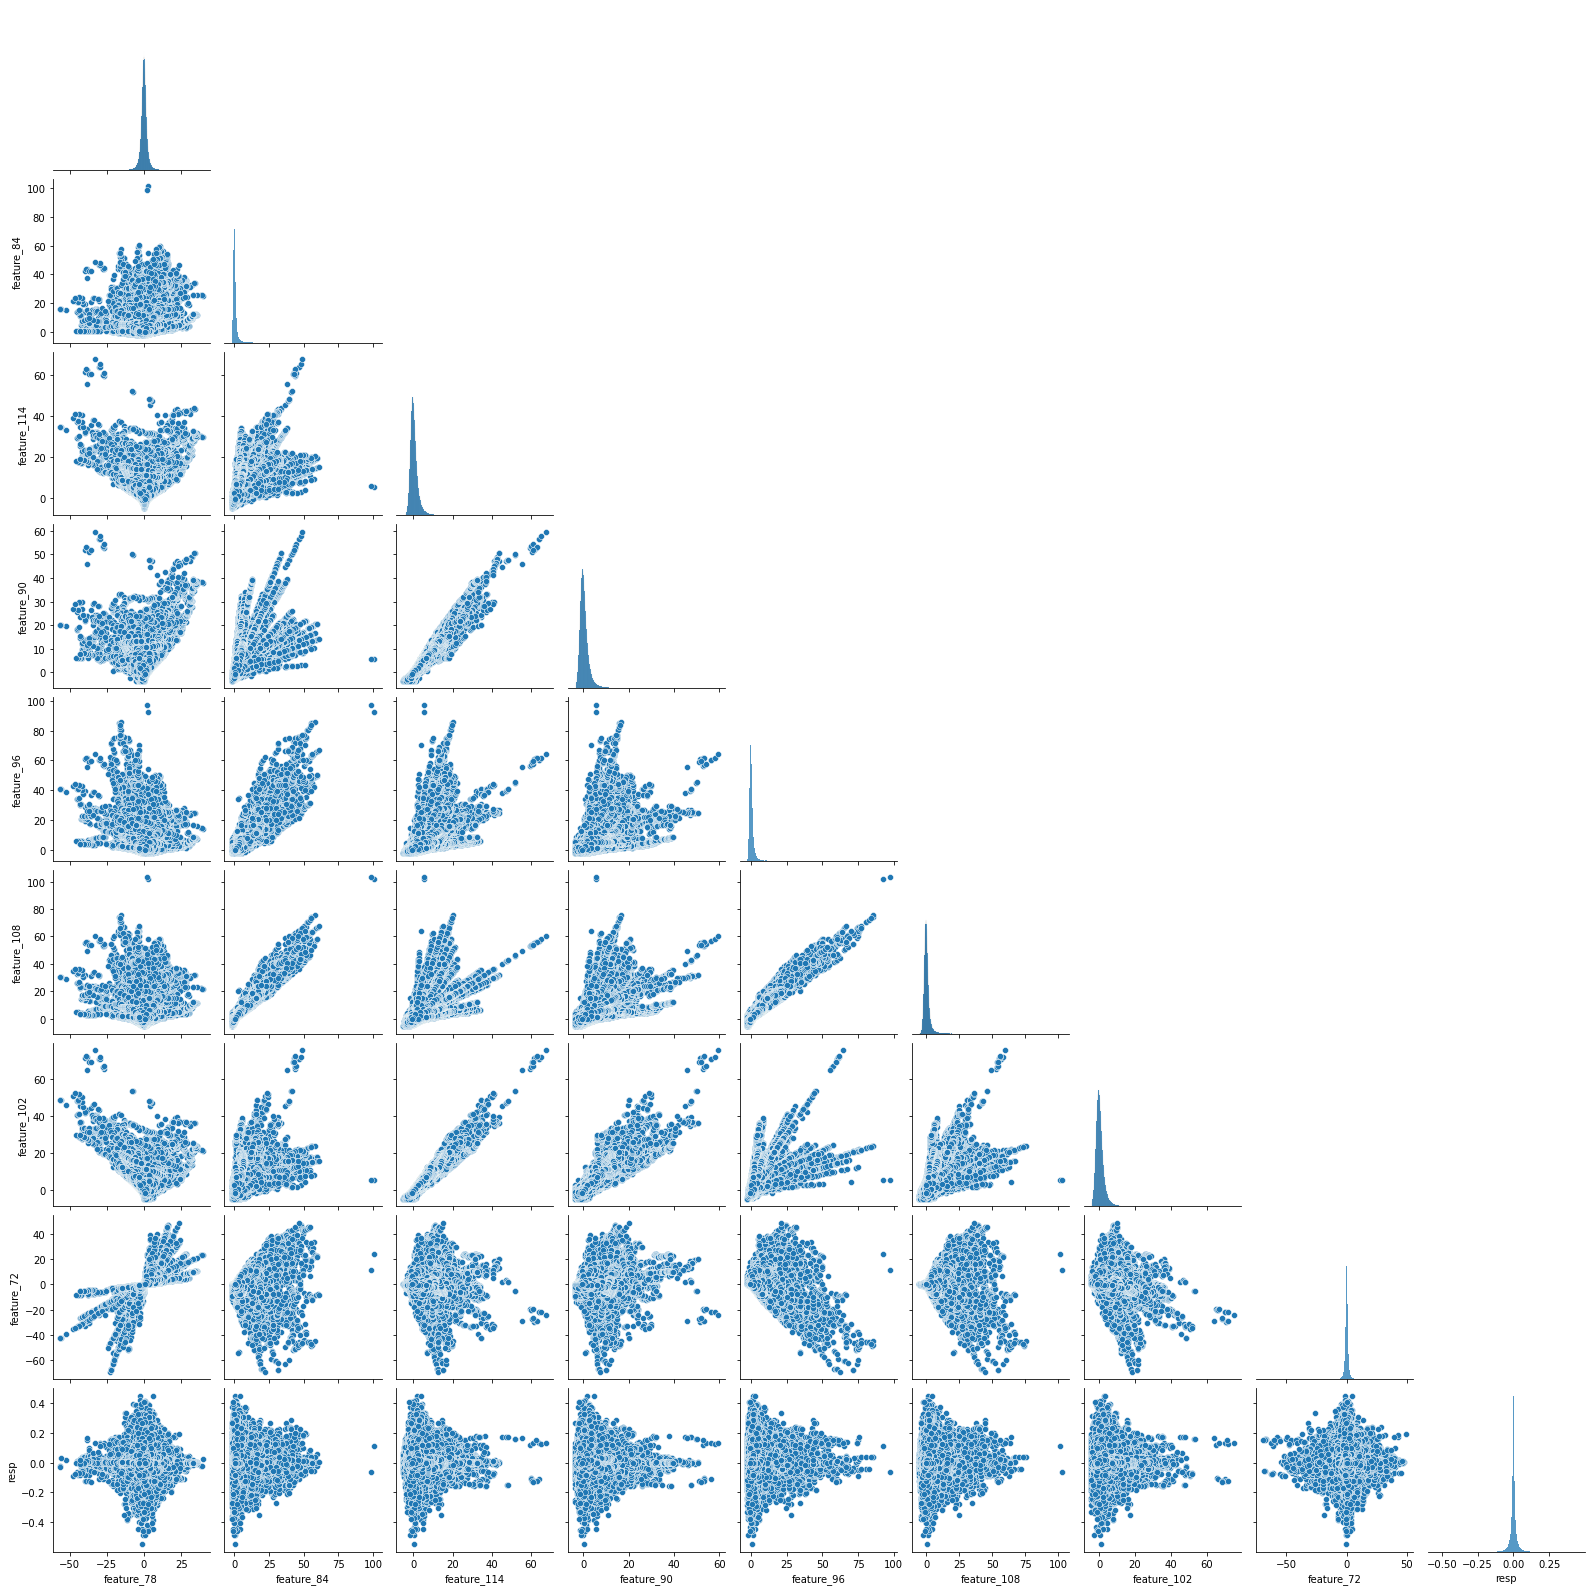

In [4]:
sns.pairplot(train[["feature_78", "feature_84", "feature_114","feature_90","feature_96", "feature_108", "feature_102","feature_72","resp"]],corner=True)

9440

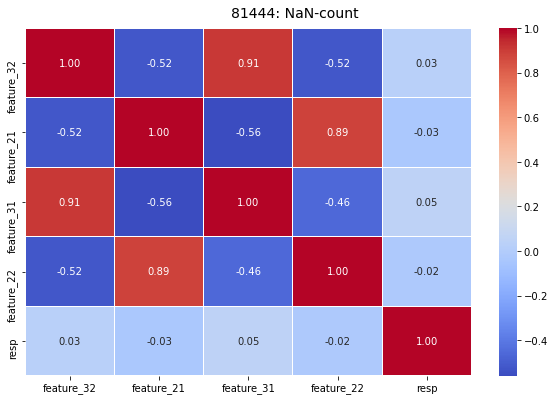

In [12]:
df81444 = train[["feature_32", "feature_21", "feature_31","feature_22","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df81444.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('81444: NaN-count', fontsize=14)
del df81444
gc.collect()

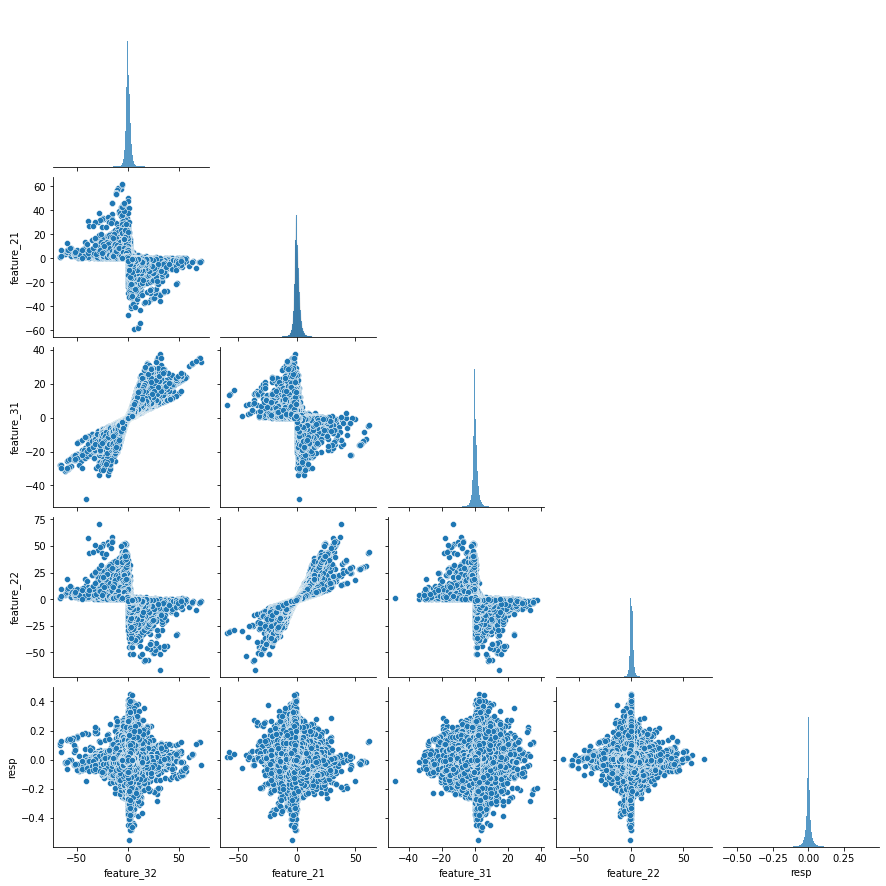

In [5]:
sns.pairplot(train[["feature_32", "feature_21", "feature_31","feature_22","resp"]],corner=True)

5881

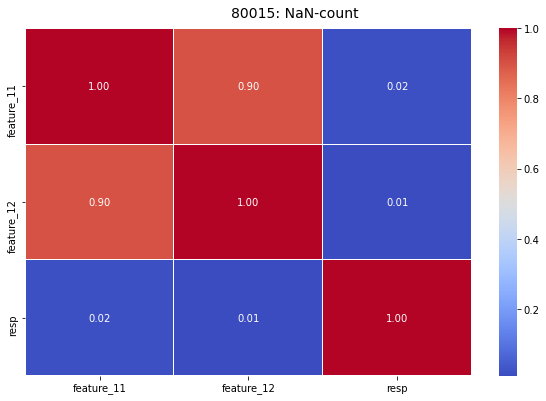

In [13]:
df80015 = train[["feature_11", "feature_12","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df80015.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('80015: NaN-count', fontsize=14)
del df80015
gc.collect()

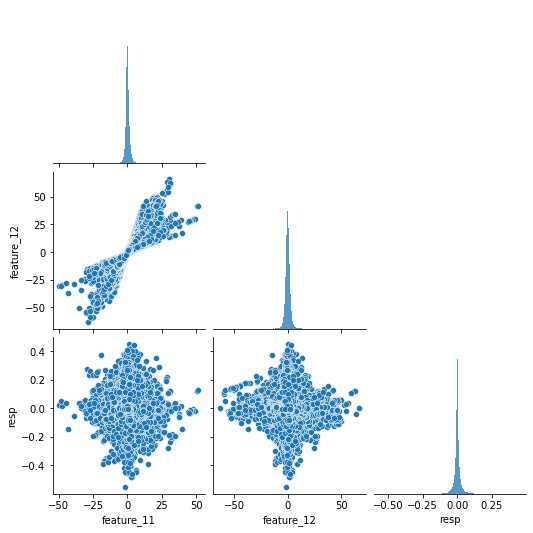

In [7]:
sns.pairplot(train[["feature_11", "feature_12","resp"]],corner=True)

4536

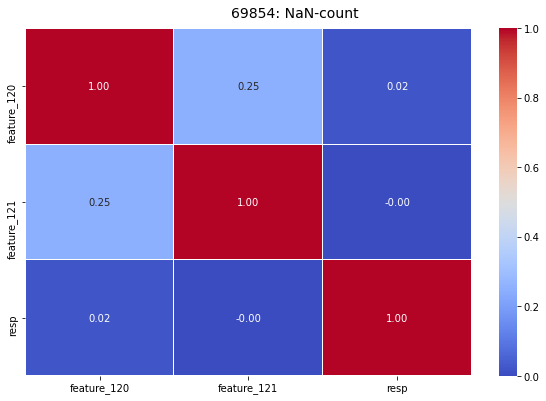

In [51]:
df69854 = train[["feature_120", "feature_121", "resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df69854.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('69854: NaN-count', fontsize=14)
del df69854
gc.collect()

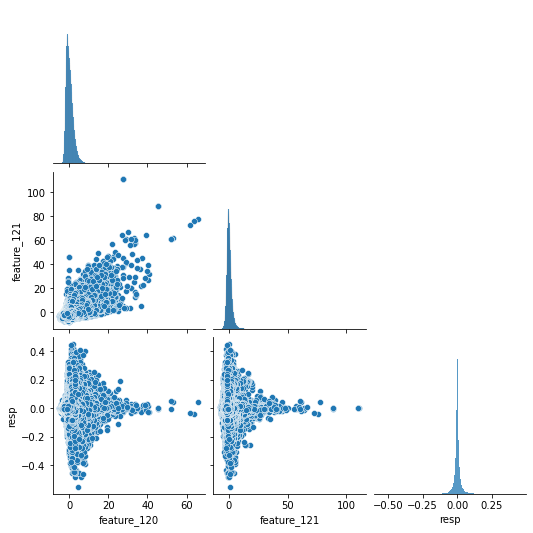

In [8]:
sns.pairplot(train[["feature_120", "feature_121","resp"]],corner=True)

4641

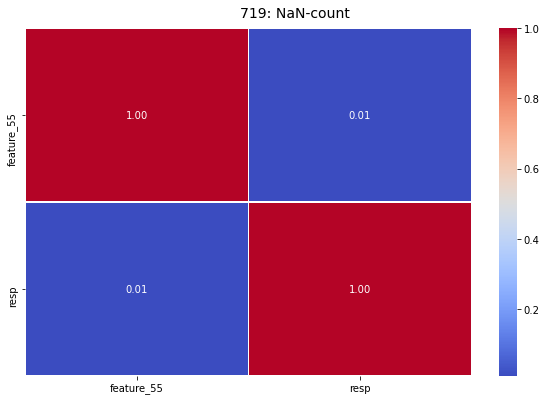

In [52]:
df719 = train[["feature_55","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df719.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('719: NaN-count', fontsize=14)
del df719
gc.collect()

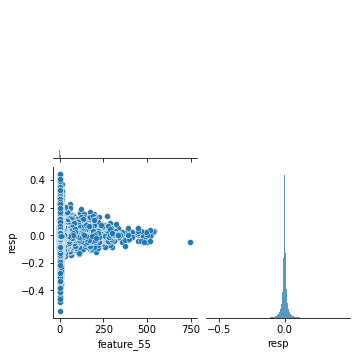

In [9]:
sns.pairplot(train[["feature_55","resp"]],corner=True)

4177

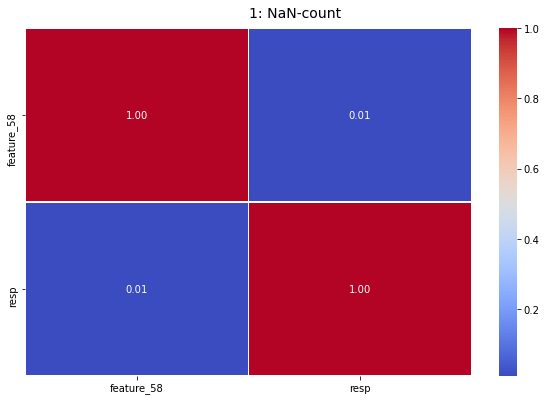

In [53]:
df1 = train[["feature_58","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df1.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('1: NaN-count', fontsize=14)
del df1
gc.collect()

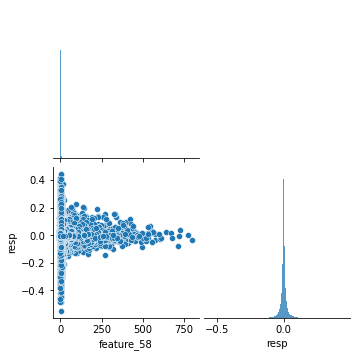

In [10]:
sns.pairplot(train[["feature_58","resp"]],corner=True)

4531

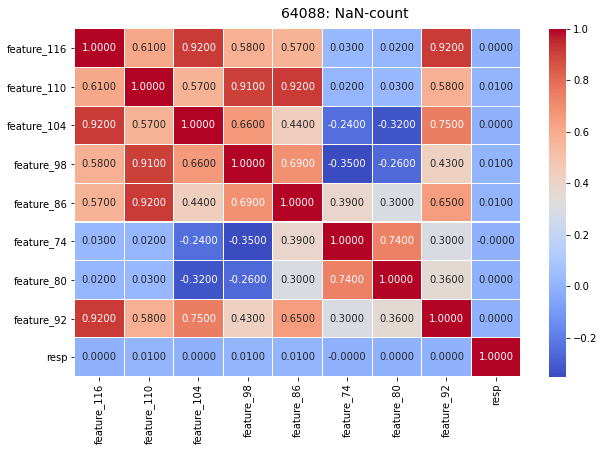

In [14]:
df64088 = train[["feature_116", "feature_110", "feature_104","feature_98","feature_86", "feature_74", "feature_80","feature_92","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df64088.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('64088: NaN-count', fontsize=14)
del df64088
gc.collect()

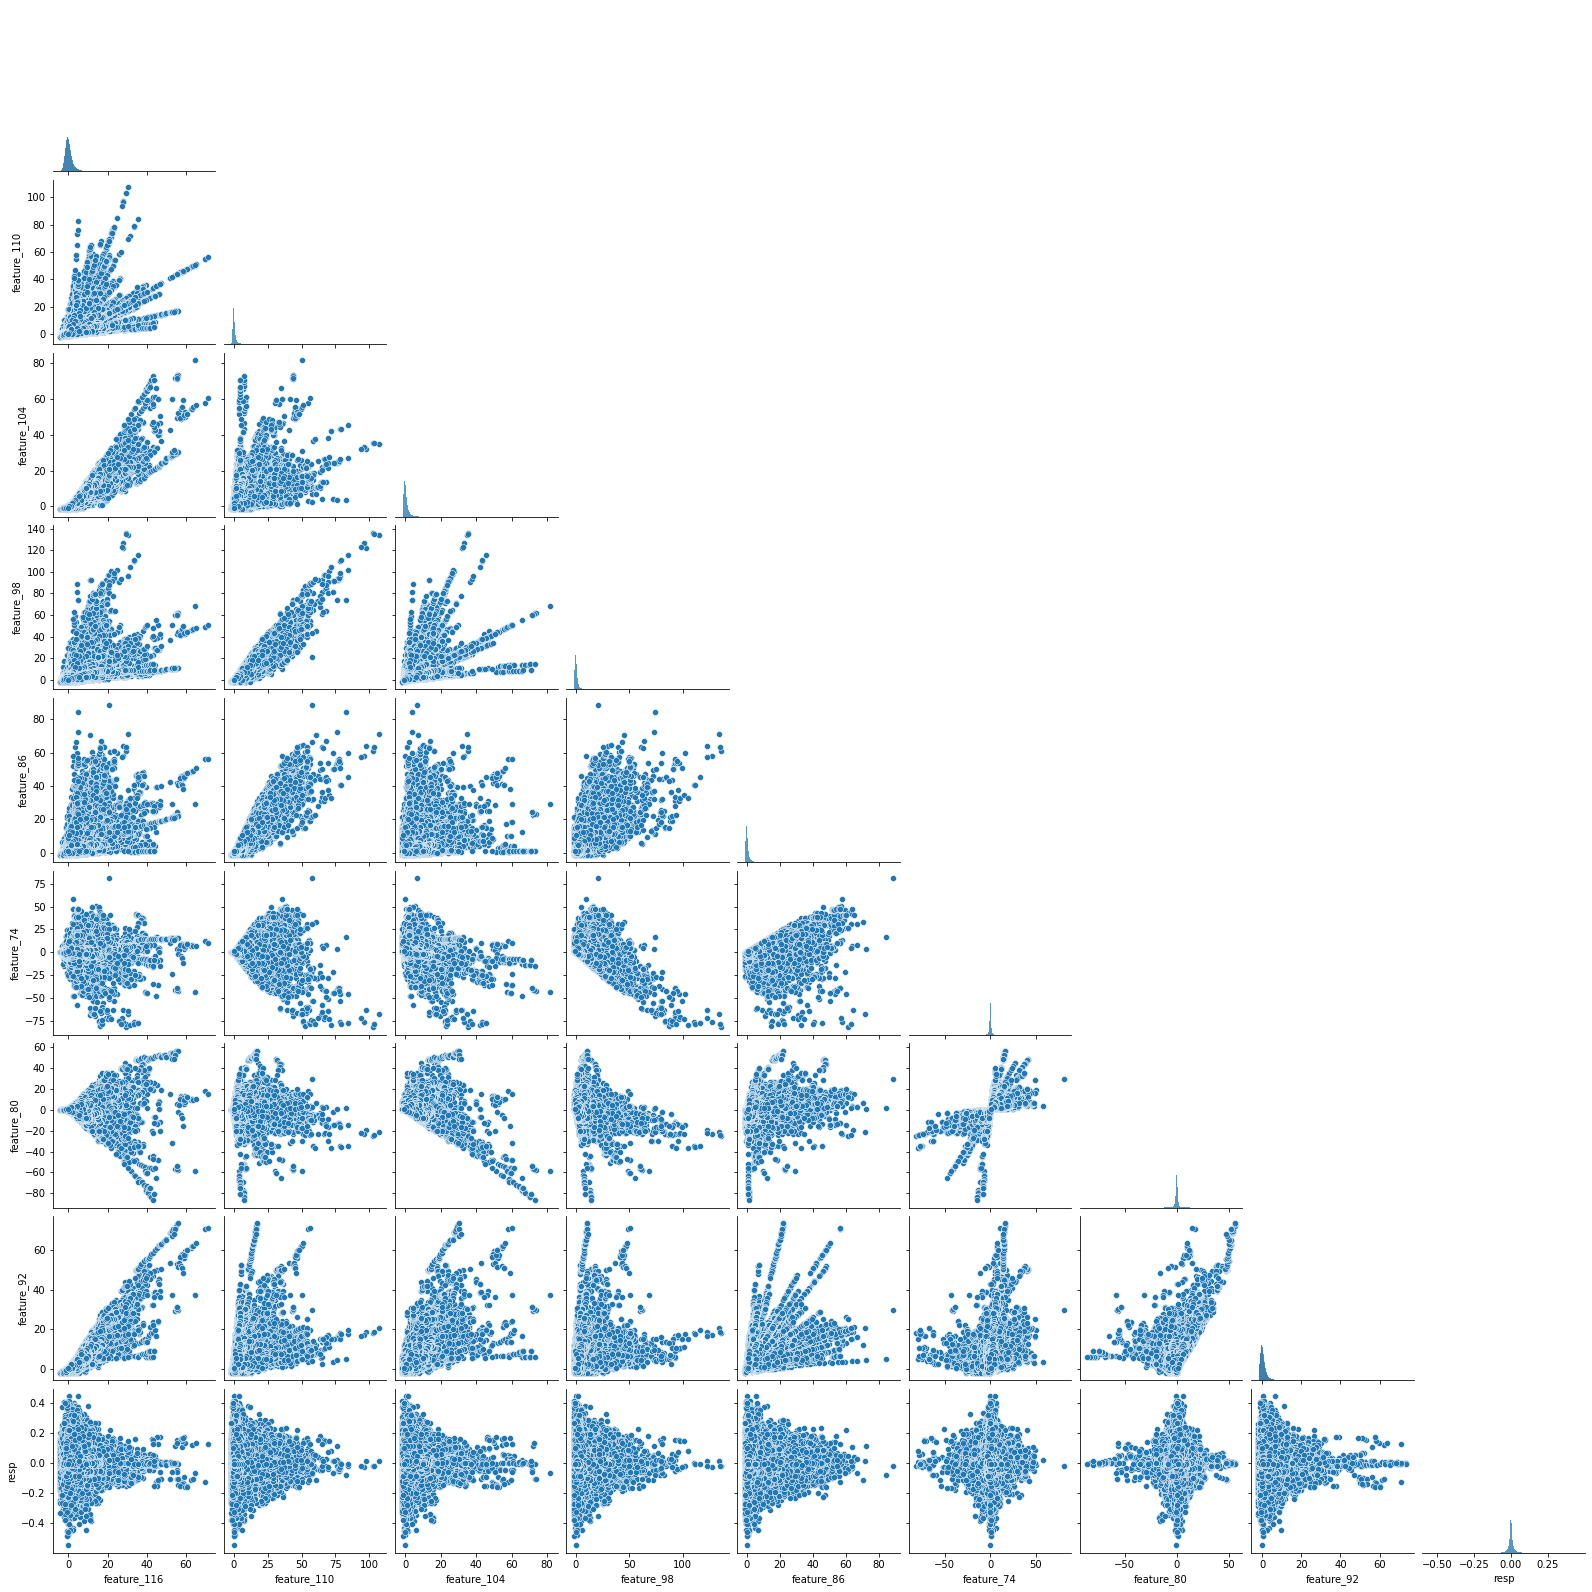

In [11]:
sns.pairplot(train[["feature_116", "feature_110", "feature_104","feature_98","feature_86", "feature_74", "feature_80","feature_92","resp"]],corner=True)

9455

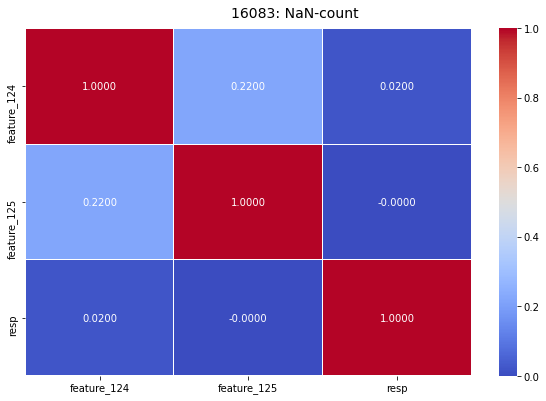

In [15]:
df16083 = train[["feature_124", "feature_125","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df16083.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('16083: NaN-count', fontsize=14)
del df16083
gc.collect()

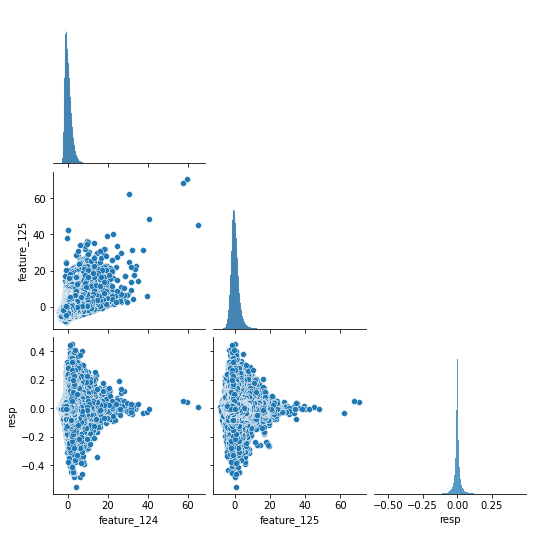

In [12]:
sns.pairplot(train[["feature_124", "feature_125","resp"]],corner=True)

18362

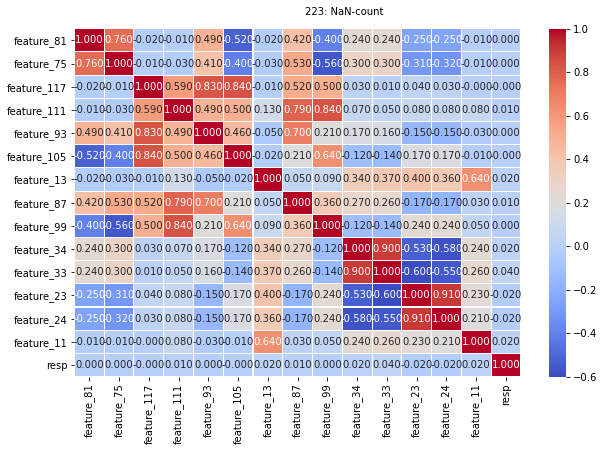

In [17]:
df15353 = train[["feature_81", "feature_75", "feature_117","feature_111","feature_93", "feature_105", "feature_13","feature_87","feature_99", "feature_34", "feature_33","feature_23","feature_24", "feature_11", "resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df15353.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.3f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=10)
del df15353
gc.collect()

In [1]:
sns.pairplot(train[["feature_81", "feature_75", "feature_117","feature_111","feature_93", "feature_105", "feature_13","feature_87","feature_99", "feature_34", "feature_33","feature_23","feature_24", "feature_11", "resp"]],corner=True)


NameError: name 'sns' is not defined

18372

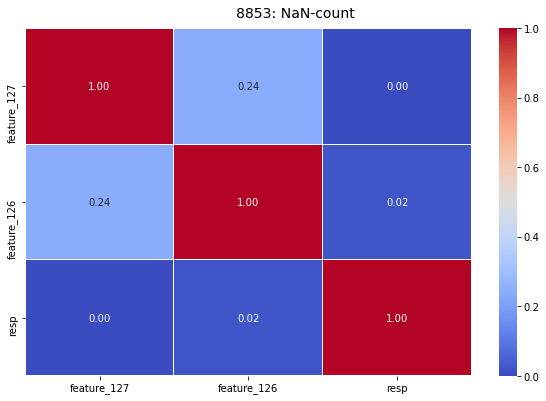

In [57]:
df8853 = train[["feature_127", "feature_126","resp"]]
f, ax = plt.subplots(figsize=(10, 6))
corr = df8853.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('8853: NaN-count', fontsize=14)
del df8853
gc.collect()

In [ ]:
sns.pairplot(train[["feature_127", "feature_126","resp"]],corner=True)

18362

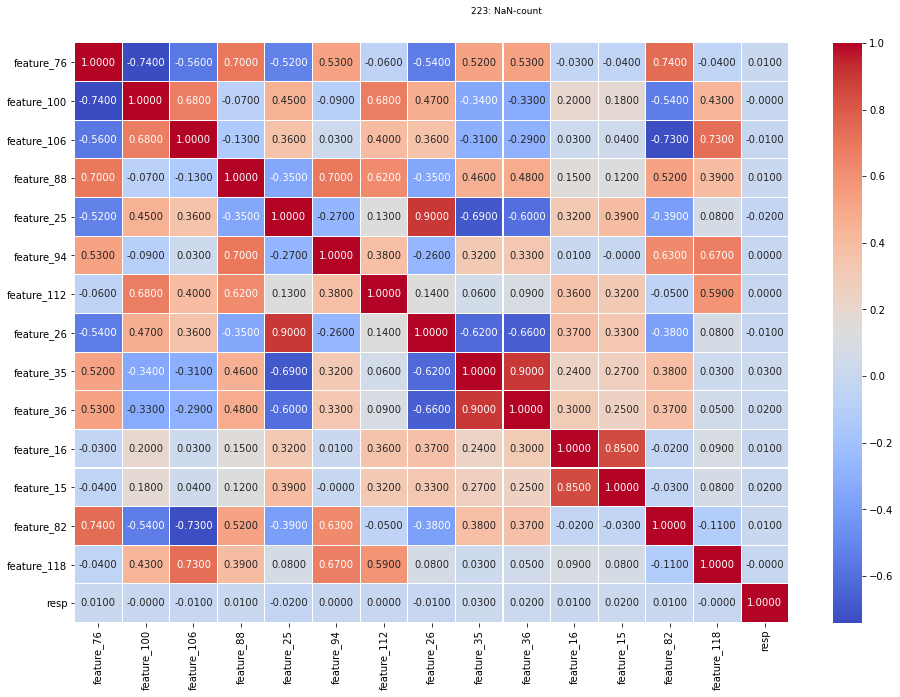

In [18]:
df6683 = train[["feature_76", "feature_100", "feature_106","feature_88", "feature_25", "feature_94","feature_112","feature_26", "feature_35", "feature_36","feature_16", "feature_15", "feature_82","feature_118","resp"]]
f, ax = plt.subplots(figsize=(16, 10))
corr = df6683.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=9)
del df6683
gc.collect()

In [ ]:
sns.pairplot(train[["feature_76", "feature_100", "feature_106","feature_88", "feature_25", "feature_94","feature_112","feature_26", "feature_35", "feature_36","feature_16", "feature_15", "feature_82","feature_118","resp"]],corner=True)



18390

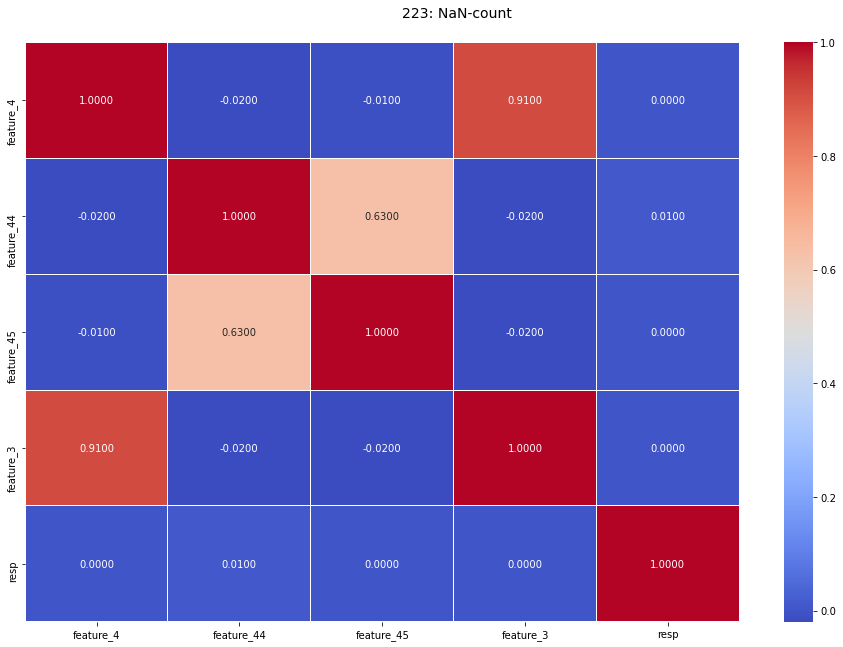

In [19]:
df448 = train[["feature_4", "feature_44", "feature_45","feature_3","resp"]]
f, ax = plt.subplots(figsize=(16, 10))
corr = df448.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=14)
del df448
gc.collect()

In [ ]:
sns.pairplot(train[["feature_4", "feature_44", "feature_45","feature_3","resp"]],corner=True)

5737

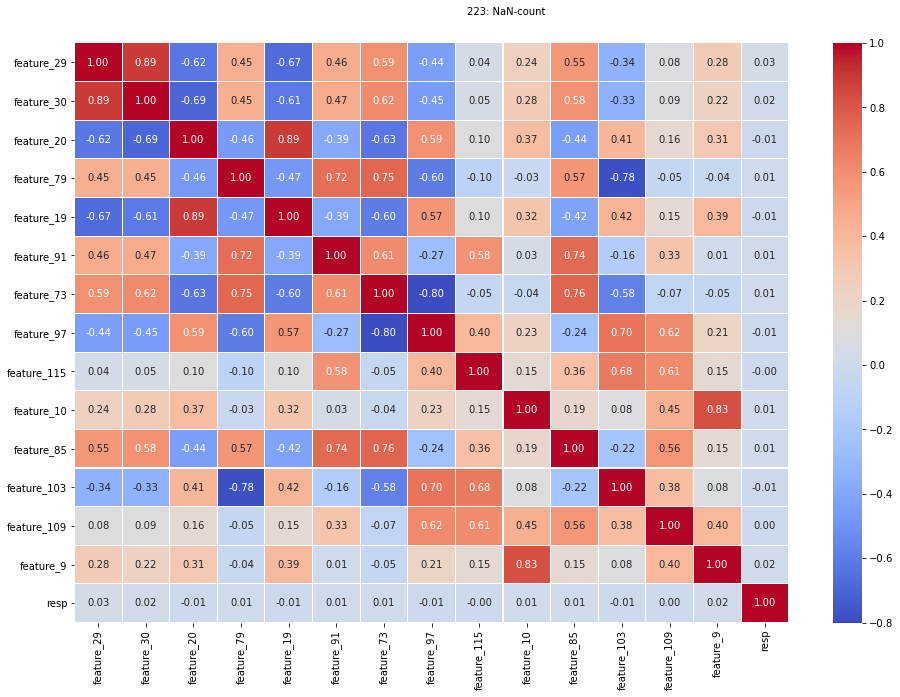

In [20]:
df788 = train[["feature_29", "feature_30", "feature_20","feature_79","feature_19","feature_91","feature_73","feature_97","feature_115","feature_10","feature_85","feature_103","feature_109","feature_9","resp"]]

f, ax = plt.subplots(figsize=(16, 10))
corr = df788.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=10)
del df788
gc.collect()

In [ ]:
sns.pairplot(train[["feature_29", "feature_30", "feature_20","feature_79","feature_19","feature_91","feature_73","feature_97","feature_115","feature_10","feature_85","feature_103","feature_109","feature_9","resp"]],corner=True)


18479

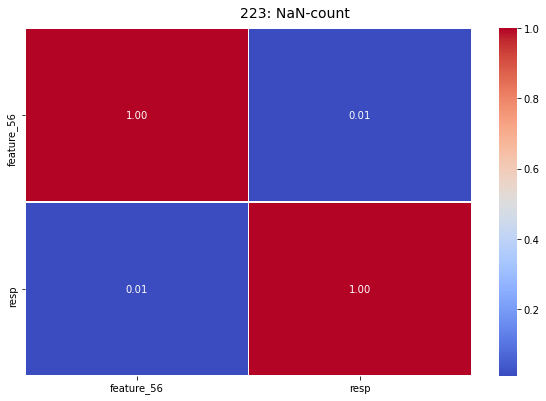

In [61]:
df719 = train[["feature_56","resp"]]

f, ax = plt.subplots(figsize=(10, 6))
corr = df719.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=14)
del df719
gc.collect()

In [ ]:
sns.pairplot(train[["feature_56","resp"]],corner=True)

4177

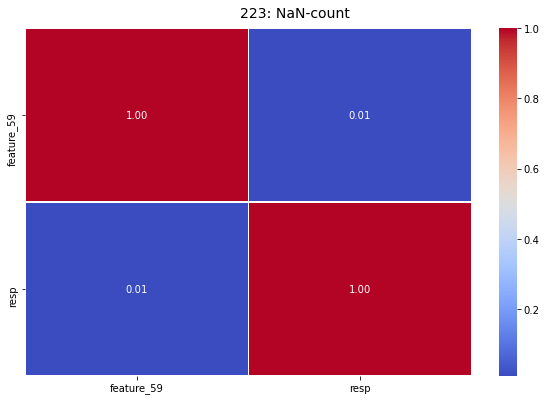

In [62]:
df48 = train[["feature_59","resp"]]

f, ax = plt.subplots(figsize=(10, 6))
corr = df48.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=14)
del df48
gc.collect()

In [ ]:
sns.pairplot(train[["feature_123","feature_129","feature_78","feature_102","feature_90","feature_114","feature_78","feature_74","feature_92","feature_80","feature_104","feature_116","feature_125","feature_99","feature_93","feature_117","feature_75","feature_81","feature_3","feature_45","feature_4","feature_109","resp"]],corner=True)

36331

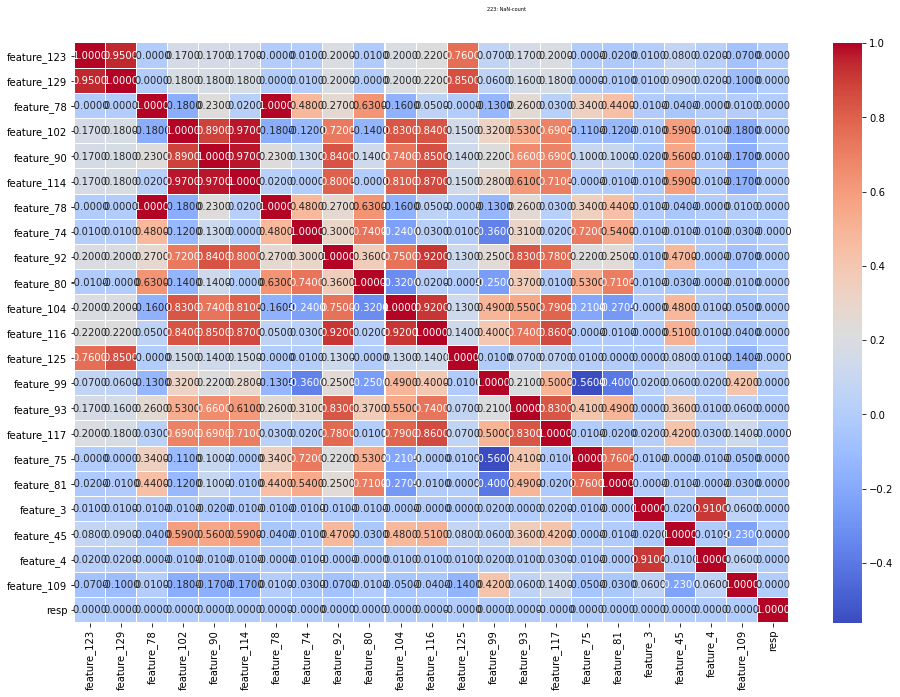

In [22]:
# Low correlation features
dflow = train[["feature_123","feature_129","feature_78","feature_102","feature_90","feature_114","feature_78","feature_74","feature_92","feature_80","feature_104","feature_116","feature_125","feature_99","feature_93","feature_117","feature_75","feature_81","feature_3","feature_45","feature_4","feature_109","resp"]]

f, ax = plt.subplots(figsize=(20, 10))
corr = dflow.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=5)
del dflow
gc.collect()

In [30]:
train.drop(["feature_129","feature_78","feature_102","feature_90","feature_114","feature_78","feature_74","feature_92","feature_80","feature_104","feature_116","feature_125","feature_99","feature_93","feature_117","feature_75","feature_81","feature_3","feature_45","feature_4","feature_109"], axis = 1, inplace = True) 
train.head()

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_118  feature_119  \
0          1  -1.872746  -2.191242  ...     6.649580    -1.472686   
1         -1  -1.349537  -1.704709  ...     1.612348    -1.664544   
2         -1   0.812780  -0.256156  ...     1.817895    -2.432424   
3         -1   1.174379   0.344640  ...     0.099560    -2.485993   
4          1  -3.172026  -3.093182  ...     2.134804    -1.279284   

   feature_120  feature_121  feature_122  feature_124  feature_126  \
0          NaN          NaN     1.168391     1.782433     2.653056   
1          NaN          NaN    -1.178850    -0.915459    -1.417010   
2          NaN          NaN     6.115747     5.542871     7.281757   
3          NaN          NaN     2.838853     3.033731     4.397532   
4          NaN          NaN     0.344850     0.614252     0.800129   

   feature_127  feature_128  ts_id  
0    12.600291     2.301488      0  
1     2.297459    -1.304614      1  
2    10.060014     6.638248      2  
3     1.266037     3.856384      3  
4     5.233243     0.362636      4  

[5 rows x 117 columns]

In [31]:
#drop null over 10% and no relation to resp fields
nulls = train.isnull().sum()
nulls_list = list(nulls[nulls >(0.1 * len(train))].index)
train.drop(columns=nulls_list,inplace=True)
train.head()

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_118  feature_119  \
0          1  -1.872746  -2.191242  ...     6.649580    -1.472686   
1         -1  -1.349537  -1.704709  ...     1.612348    -1.664544   
2         -1   0.812780  -0.256156  ...     1.817895    -2.432424   
3         -1   1.174379   0.344640  ...     0.099560    -2.485993   
4          1  -3.172026  -3.093182  ...     2.134804    -1.279284   

   feature_120  feature_121  feature_122  feature_124  feature_126  \
0          NaN          NaN     1.168391     1.782433     2.653056   
1          NaN          NaN    -1.178850    -0.915459    -1.417010   
2          NaN          NaN     6.115747     5.542871     7.281757   
3          NaN          NaN     2.838853     3.033731     4.397532   
4          NaN          NaN     0.344850     0.614252     0.800129   

   feature_127  feature_128  ts_id  
0    12.600291     2.301488      0  
1     2.297459    -1.304614      1  
2    10.060014     6.638248      2  
3     1.266037     3.856384      3  
4     5.233243     0.362636      4  

[5 rows x 107 columns]

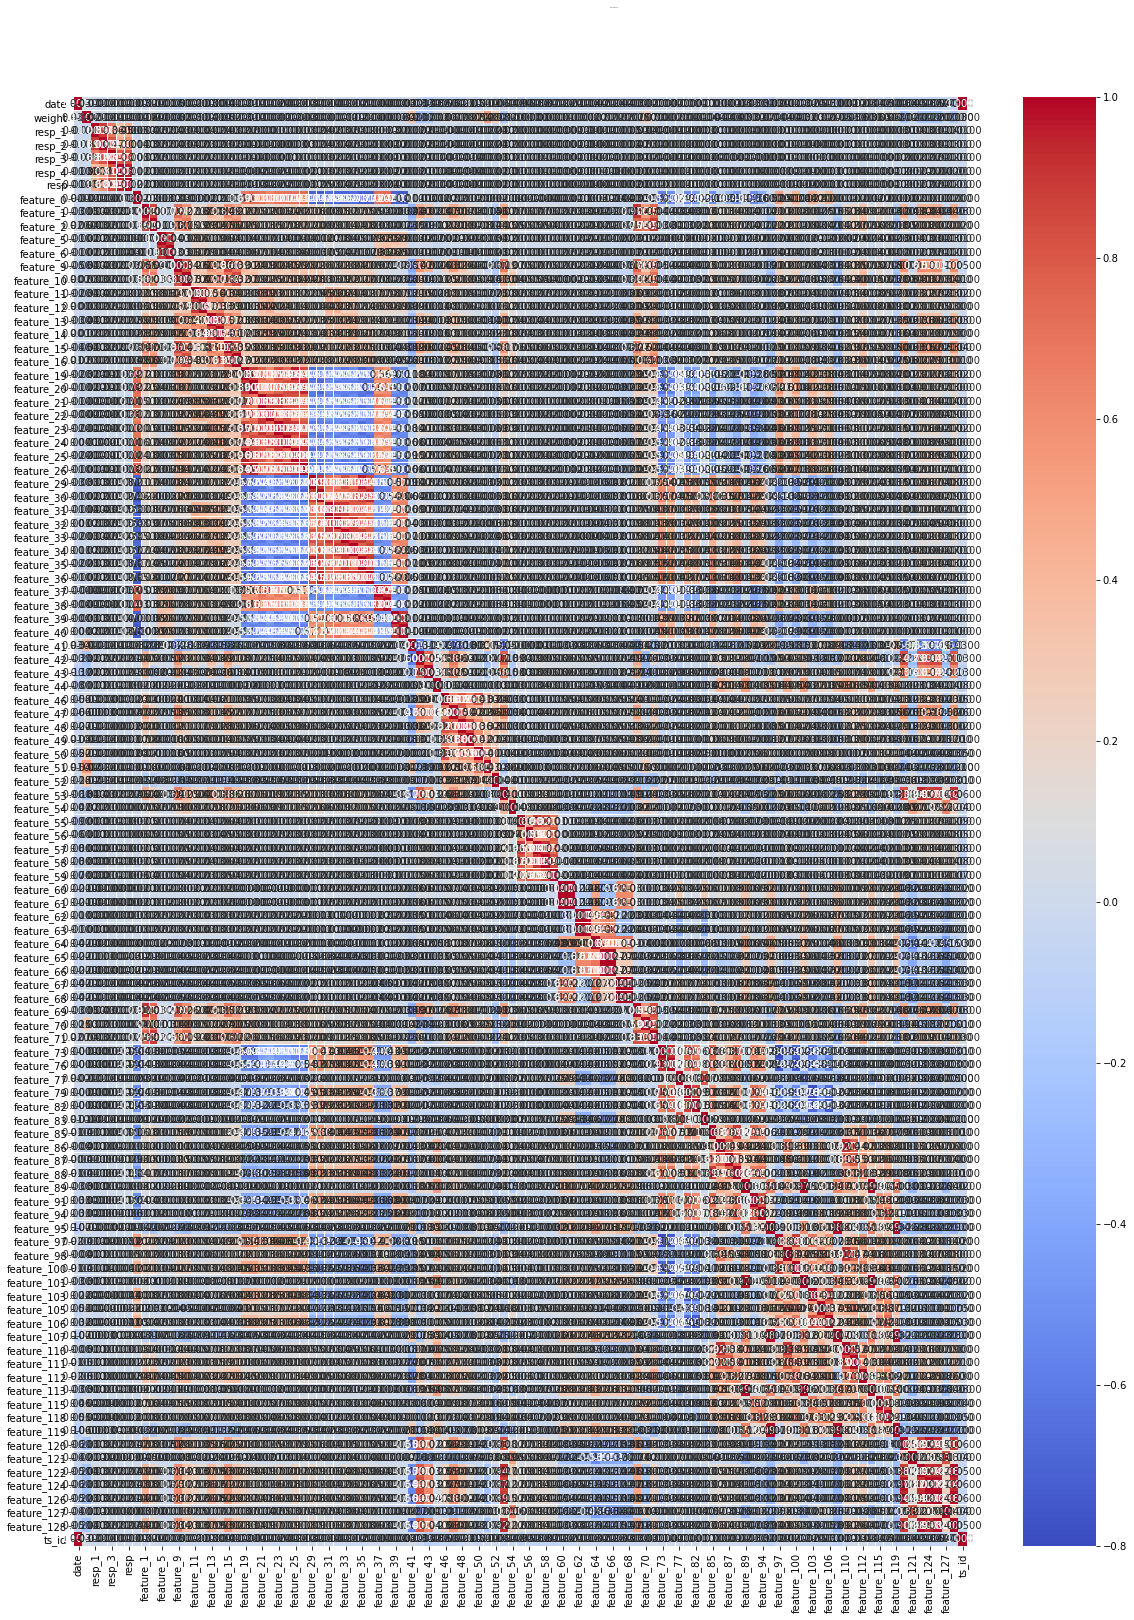

In [33]:
#Correlation of the remaining columns
f, ax = plt.subplots(figsize=(20, 25))
corr = train.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.4f',linewidths=.001)
f.subplots_adjust(top=0.93)
t= f.suptitle('223: NaN-count', fontsize=1)

